In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
# from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\ferra\OneDrive\Documentos\Ubiqum\The Credit One Project\credit_one.csv")
df = df.drop('ID', axis=1) # Treiem columna ID
df.rename(columns={'PAY_0': 'PAY_1'}, inplace=True) # Substituïr PAY_0 per PAY_1 per mantenir una cronología
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
# Creo 3 Variables de 'Comportament'
df['PAY_1_ontime'] = (df['PAY_1'] == -1).astype(int) # astype converteix el Boolean (True/False) en int (numèric) # Pagaments a temps
df['PAY_1_sensemov'] = (df['PAY_1'] == -2).astype(int) # Sense moviment
df['PAY_1_revolving'] = (df['PAY_1'] == 0).astype(int) # Revolving
# Creo 1 Variable de 'Ordinalitat'
df['PAY_1_mesos_retard'] = df['PAY_1'].apply(lambda x: x if x > 0 else 0) # Creació d'una variable indicadora de retard
# la funció lambda (anònima) s'aplica de tal manera que converteix en 0 els valors mes petits o iguals a cero i la resta els deixa IGUAL
df = df.drop(columns=['PAY_1']) # ens petem PAY_1, doncs ja no ens cal
df['PAY_2_ontime'] = (df['PAY_2'] == -1).astype(int)
df['PAY_2_sensemov'] = (df['PAY_2'] == -2).astype(int)
df['PAY_2_revolving'] = (df['PAY_2'] == 0).astype(int)
df['PAY_2_mesos_retard'] = df['PAY_2'].apply(lambda x: x if x > 0 else 0)
df = df.drop(columns=['PAY_2'])
df['PAY_3_ontime'] = (df['PAY_3'] == -1).astype(int)
df['PAY_3_sensemov'] = (df['PAY_3'] == -2).astype(int)
df['PAY_3_revolving'] = (df['PAY_3'] == 0).astype(int)
df['PAY_3_mesos_retard'] = df['PAY_3'].apply(lambda x: x if x > 0 else 0)
df = df.drop(columns=['PAY_3'])
df['PAY_4_ontime'] = (df['PAY_4'] == -1).astype(int)
df['PAY_4_sensemov'] = (df['PAY_4'] == -2).astype(int)
df['PAY_4_revolving'] = (df['PAY_4'] == 0).astype(int)
df['PAY_4_mesos_retard'] = df['PAY_4'].apply(lambda x: x if x > 0 else 0)
df = df.drop(columns=['PAY_4'])
df['PAY_5_ontime'] = (df['PAY_5'] == -1).astype(int)
df['PAY_5_sensemov'] = (df['PAY_5'] == -2).astype(int)
df['PAY_5_revolving'] = (df['PAY_5'] == 0).astype(int)
df['PAY_5_mesos_retard'] = df['PAY_5'].apply(lambda x: x if x > 0 else 0)
df = df.drop(columns=['PAY_5'])
df['PAY_6_ontime'] = (df['PAY_6'] == -1).astype(int)
df['PAY_6_sensemov'] = (df['PAY_6'] == -2).astype(int)
df['PAY_6_revolving'] = (df['PAY_6'] == 0).astype(int)
df['PAY_6_mesos_retard'] = df['PAY_6'].apply(lambda x: x if x > 0 else 0)
df = df.drop(columns=['PAY_6'])
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,...,PAY_4_revolving,PAY_4_mesos_retard,PAY_5_ontime,PAY_5_sensemov,PAY_5_revolving,PAY_5_mesos_retard,PAY_6_ontime,PAY_6_sensemov,PAY_6_revolving,PAY_6_mesos_retard
0,20000,2,2,1,24,3913,3102,689,0,0,...,0,0,0,1,0,0,0,1,0,0
1,120000,2,2,2,26,2682,1725,2682,3272,3455,...,1,0,0,0,1,0,0,0,0,2
2,90000,2,2,2,34,29239,14027,13559,14331,14948,...,1,0,0,0,1,0,0,0,1,0
3,50000,2,2,1,37,46990,48233,49291,28314,28959,...,1,0,0,0,1,0,0,0,1,0
4,50000,1,2,1,57,8617,5670,35835,20940,19146,...,1,0,0,0,1,0,0,0,1,0


In [4]:
cols1 = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
df['BILL_AMT_AGRUPAT'] = df[cols1].mean(axis=1)
df.drop(cols1, axis=1, inplace=True)
cols2 = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df['PAY_AMT_AGRUPAT'] = df[cols2].mean(axis=1)
df.drop(cols2, axis=1, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default payment next month,PAY_1_ontime,PAY_1_sensemov,PAY_1_revolving,PAY_1_mesos_retard,...,PAY_5_ontime,PAY_5_sensemov,PAY_5_revolving,PAY_5_mesos_retard,PAY_6_ontime,PAY_6_sensemov,PAY_6_revolving,PAY_6_mesos_retard,BILL_AMT_AGRUPAT,PAY_AMT_AGRUPAT
0,20000,2,2,1,24,1,0,0,0,2,...,0,1,0,0,0,1,0,0,1284.000000,114.833333
1,120000,2,2,2,26,1,1,0,0,0,...,0,0,1,0,0,0,0,2,2846.166667,833.333333
2,90000,2,2,2,34,0,0,0,1,0,...,0,0,1,0,0,0,1,0,16942.166667,1836.333333
3,50000,2,2,1,37,0,0,0,1,0,...,0,0,1,0,0,0,1,0,38555.666667,1398.000000
4,50000,1,2,1,57,0,1,0,0,0,...,0,0,1,0,0,0,1,0,18223.166667,9841.500000


In [5]:
etiquetes = {1: 'male', 2: 'female'}
df['SEX'] = df['SEX'].map(etiquetes)
encoder = OneHotEncoder(sparse_output=False, drop='first')
df_codificat = pd.DataFrame(encoder.fit_transform(df[['SEX']]), columns=encoder.get_feature_names_out(['SEX']), index=df.index)
df_final = df.drop(columns=['SEX']).join(df_codificat)
df_final.head()
df = df_final
df.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,default payment next month,PAY_1_ontime,PAY_1_sensemov,PAY_1_revolving,PAY_1_mesos_retard,PAY_2_ontime,...,PAY_5_sensemov,PAY_5_revolving,PAY_5_mesos_retard,PAY_6_ontime,PAY_6_sensemov,PAY_6_revolving,PAY_6_mesos_retard,BILL_AMT_AGRUPAT,PAY_AMT_AGRUPAT,SEX_male
0,20000,2,1,24,1,0,0,0,2,0,...,1,0,0,0,1,0,0,1284.000000,114.833333,0.0
1,120000,2,2,26,1,1,0,0,0,0,...,0,1,0,0,0,0,2,2846.166667,833.333333,0.0
2,90000,2,2,34,0,0,0,1,0,0,...,0,1,0,0,0,1,0,16942.166667,1836.333333,0.0
3,50000,2,1,37,0,0,0,1,0,0,...,0,1,0,0,0,1,0,38555.666667,1398.000000,0.0
4,50000,2,1,57,0,1,0,0,0,0,...,0,1,0,0,0,1,0,18223.166667,9841.500000,1.0


In [6]:
map = {1: 'postgrau',2: 'universitari',3: 'secundaria',4: 'altres'}
df['EDUCATION'] = df['EDUCATION'].map(map)
df['EDUCATION'] = df['EDUCATION'].fillna('altres') # Gestió de valors no mapejats (ex: 0, 5, 6): els assignem a 'altres'
columna_a_codificar = df[['EDUCATION']]
df_restant = df.drop(columns=['EDUCATION'])
encoder = OneHotEncoder(sparse_output=False, drop='first')
dades_codificades = encoder.fit_transform(columna_a_codificar)
df_codificat = pd.DataFrame(dades_codificades, columns=encoder.get_feature_names_out(['EDUCATION']))
# Unim les dades restants amb les noves columnes codificades
df_final = pd.concat([df_restant, df_codificat], axis=1)
# Creem un DataFrame amb totes les columnes menys 'EDUCATION'
df_restant = df.drop(columns=['EDUCATION'])
# Unim els dos DataFrames, un al costat de l'altre
df_final = pd.concat([df_restant, df_codificat], axis=1)
# 3. MOSTRAR RESULTAT
print("DataFrame Final amb la columna 'EDUCATION' codificada:")
df = df_final
df.head()

DataFrame Final amb la columna 'EDUCATION' codificada:


,LIMIT_BAL,MARRIAGE,AGE,default payment next month,PAY_1_ontime,PAY_1_sensemov,PAY_1_revolving,PAY_1_mesos_retard,PAY_2_ontime,PAY_2_sensemov,...,PAY_6_ontime,PAY_6_sensemov,PAY_6_revolving,PAY_6_mesos_retard,BILL_AMT_AGRUPAT,PAY_AMT_AGRUPAT,SEX_male,EDUCATION_postgrau,EDUCATION_secundaria,EDUCATION_universitari
0,20000,1,24,1,0,0,0,2,0,0,...,0,1,0,0,1284.000000,114.833333,0.0,0.0,0.0,1.0
1,120000,2,26,1,1,0,0,0,0,0,...,0,0,0,2,2846.166667,833.333333,0.0,0.0,0.0,1.0
2,90000,2,34,0,0,0,1,0,0,0,...,0,0,1,0,16942.166667,1836.333333,0.0,0.0,0.0,1.0
3,50000,1,37,0,0,0,1,0,0,0,...,0,0,1,0,38555.666667,1398.000000,0.0,0.0,0.0,1.0
4,50000,1,57,0,1,0,0,0,0,0,...,0,0,1,0,18223.166667,9841.500000,1.0,0.0,0.0,1.0


In [7]:
labels = {1: 'casat',2: 'solter',3: 'altres'}
df['MARRIAGE'] = df['MARRIAGE'].map(labels)
encoder = OneHotEncoder(sparse_output=False, drop='first')
df_codificat = pd.DataFrame(encoder.fit_transform(df[['MARRIAGE']]), columns=encoder.get_feature_names_out(['MARRIAGE']), index=df.index)
df_final = df.drop(columns=['MARRIAGE']).join(df_codificat)
df_final
df = df_final
df.head()

,LIMIT_BAL,AGE,default payment next month,PAY_1_ontime,PAY_1_sensemov,PAY_1_revolving,PAY_1_mesos_retard,PAY_2_ontime,PAY_2_sensemov,PAY_2_revolving,...,PAY_6_mesos_retard,BILL_AMT_AGRUPAT,PAY_AMT_AGRUPAT,SEX_male,EDUCATION_postgrau,EDUCATION_secundaria,EDUCATION_universitari,MARRIAGE_casat,MARRIAGE_solter,MARRIAGE_nan
0,20000,24,1,0,0,0,2,0,0,0,...,0,1284.000000,114.833333,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,120000,26,1,1,0,0,0,0,0,0,...,2,2846.166667,833.333333,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,90000,34,0,0,0,1,0,0,0,1,...,0,16942.166667,1836.333333,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,50000,37,0,0,0,1,0,0,0,1,...,0,38555.666667,1398.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,50000,57,0,1,0,0,0,0,0,1,...,0,18223.166667,9841.500000,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [8]:
df.rename(columns={'default payment next month': 'default'}, inplace=True)
df.head()

,LIMIT_BAL,AGE,default,PAY_1_ontime,PAY_1_sensemov,PAY_1_revolving,PAY_1_mesos_retard,PAY_2_ontime,PAY_2_sensemov,PAY_2_revolving,...,PAY_6_mesos_retard,BILL_AMT_AGRUPAT,PAY_AMT_AGRUPAT,SEX_male,EDUCATION_postgrau,EDUCATION_secundaria,EDUCATION_universitari,MARRIAGE_casat,MARRIAGE_solter,MARRIAGE_nan
0,20000,24,1,0,0,0,2,0,0,0,...,0,1284.000000,114.833333,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,120000,26,1,1,0,0,0,0,0,0,...,2,2846.166667,833.333333,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,90000,34,0,0,0,1,0,0,0,1,...,0,16942.166667,1836.333333,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,50000,37,0,0,0,1,0,0,0,1,...,0,38555.666667,1398.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,50000,57,0,1,0,0,0,0,0,1,...,0,18223.166667,9841.500000,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [9]:
y = df['default']
X = df.drop(columns=['default'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
])
params = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [3, 4],
    'xgb__min_child_weight': [20, 50, 100],
    'xgb__learning_rate': [0.01]   # learning rate (eta)
}
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv_strategy,
    scoring='recall',
    n_jobs=-1,
    verbose=2
)
print("GridSearchCV configurat i a punt per entrenar.")
grid_search.fit(X_train, y_train)  # <-- Important!
print("Entrenament completat!")
print(f"Millors paràmetres trobats: {grid_search.best_params_}")
print(f"Millor puntuació F1 amb CV: {grid_search.best_score_:.4f}")
preds = grid_search.predict(X_test)
print(classification_report(y_test, preds))

GridSearchCV configurat i a punt per entrenar.
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Entrenament completat!
Millors paràmetres trobats: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__min_child_weight': 100, 'xgb__n_estimators': 50}
Millor puntuació F1 amb CV: 0.5436
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4673
           1       0.50      0.52      0.51      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.69      0.68      6000
weighted avg       0.78      0.78      0.78      6000



Millors paràmetres trobats: {'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__min_child_weight': 175, 'xgb__n_estimators': 195, 'xgb__subsample': 0.6}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
hiperparametres_xgb = {
    'n_estimators': 150,
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42
}
# Learning Rate 0.001 i 0.01 i 0.1
algo = XGBClassifier(**hiperparametres_xgb)
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

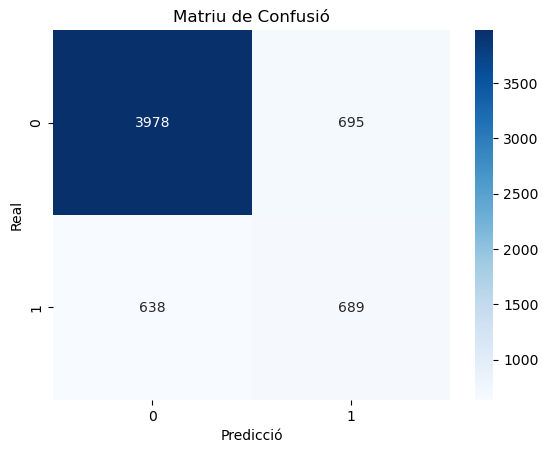

In [12]:
cm = confusion_matrix(y_test, preds)
cm
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicció")
plt.ylabel("Real")
plt.title("Matriu de Confusió")
plt.show()

In [13]:
# TP = 684
# TN = 3978
# FN = 643 * ES EL QUE VULL DISMINUIR PER A MILLOR RECALL I AIXÍ TROBAR EL MAJOR Nº D'IMPAGAMENTS
# FP = 695

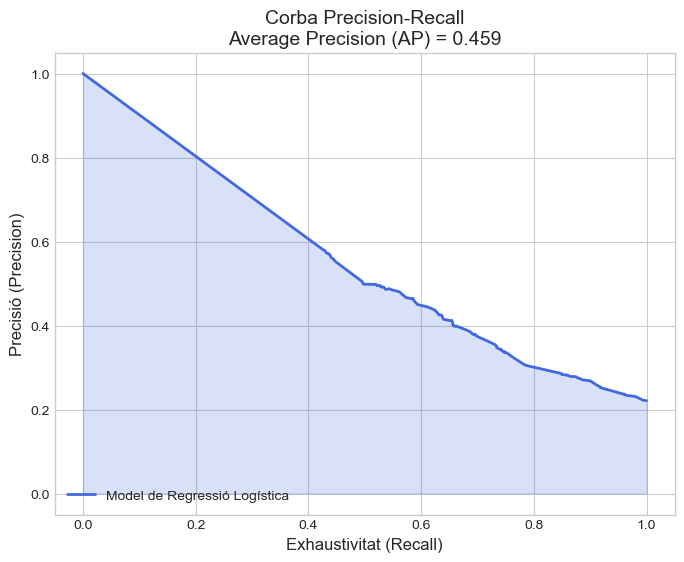

In [14]:
# --- 7. Obtenció de les Probabilitats i Càlcul de la Corba ---
y_scores = grid_search.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap_score = average_precision_score(y_test, y_scores)
# --- 8. Dibuix de la Corba ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='royalblue', lw=2, label=f'Model de Regressió Logística')
plt.fill_between(recall, precision, alpha=0.2, color='royalblue')
plt.xlabel('Exhaustivitat (Recall)', fontsize=12)
plt.ylabel('Precisió (Precision)', fontsize=12)
plt.title(f'Corba Precision-Recall\nAverage Precision (AP) = {ap_score:.3f}', fontsize=14)
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

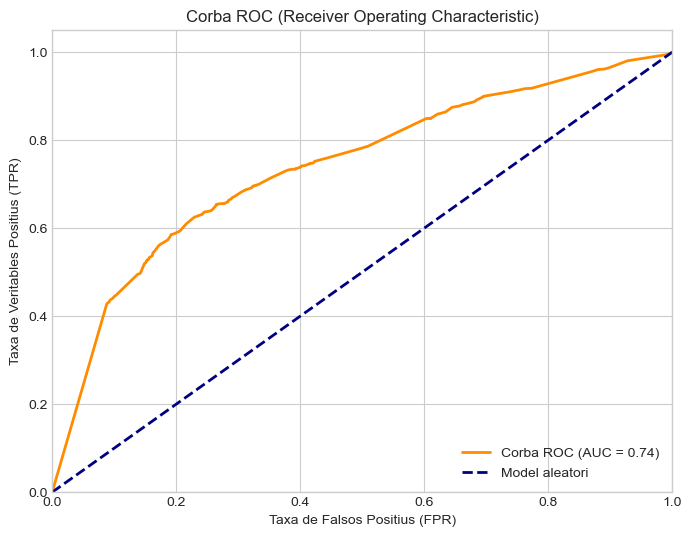

In [15]:
# --- 7. Gràfic de la Corba ROC ---
# Calculem la taxa de veritables positius (tpr) i la taxa de falsos positius (fpr)
fpr, tpr, _ = roc_curve(y_test, y_scores)
# Calculem l'àrea sota la corba ROC (AUC)
roc_auc = auc(fpr, tpr)
# Dibuixem la corba ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Corba ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Model aleatori') # Línia de referència
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positius (FPR)')
plt.ylabel('Taxa de Veritables Positius (TPR)')
plt.title('Corba ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [16]:
# Threshold Tuning

In [17]:
millor_model_optimitzat = grid_search.best_estimator_
probabilitats = millor_model_optimitzat.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probabilitats)
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
millor_llindar = thresholds[np.argmax(f1_scores)]
print("-" * 50)
print(f"Llindar per defecte: 0.5")
print(f"Millor llindar trobat per maximitzar F1-score: {millor_llindar:.4f}")
print("-" * 50)
prediccions_finals_ajustades = (probabilitats >= millor_llindar).astype(int)
print("Nou Classification Report amb el llindar ajustat:")
print(classification_report(y_test, prediccions_finals_ajustades))

--------------------------------------------------
Llindar per defecte: 0.5
Millor llindar trobat per maximitzar F1-score: 0.4515
--------------------------------------------------
Nou Classification Report amb el llindar ajustat:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      4673
           1       0.46      0.59      0.52      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.78      0.76      0.77      6000

